In [1]:
# Hide warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import required libraries.
import ast
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers, models
import wfdb

### Load Data

In [3]:
# All the code in this cell (except the last line) is from the site that provided our dataset.
# Load the data and assign diagnostic classes to each example.
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100
Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
X = load_raw_data(Y, sampling_rate, path)
agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp)) 

Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: x[0] if len(x) > 0 else 'NORM') # Select the first EKG class if an example has more than one.

In [4]:
X[0] # First example

array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
       [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
       [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
       ...,
       [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
       [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
       [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]])

In [5]:
y = Y['diagnostic_superclass'].to_numpy()
classes, counts = np.unique(y, return_counts=True) # Show the number of examples in each EKG class. 
classes, counts 

(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object),
 array([1708, 2385, 3829, 9887, 3990]))

In [6]:
# Split the data into train (80%) and test (20%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True) 

In [7]:
y_train.shape # Show the number of training examples.

(17439,)

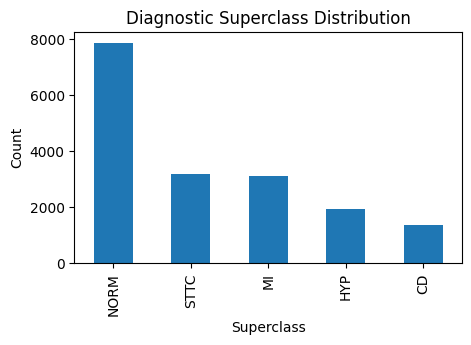

In [8]:
# Plot the distribution of examples across each EKG class in the training data. 
plt.figure(figsize=(5,3)) # Sets the figure size.
pd.Series(y_train).value_counts().plot(kind='bar') # Plots a bar chart of the counts of each EKG class. 
plt.title('Diagnostic Superclass Distribution') # Sets title.
plt.xlabel('Superclass') # Sets the x label.
plt.ylabel('Count') # Sets the y label.
plt.show() # Displays the plot.

In [9]:
train_classes, train_counts = np.unique(y_train, return_counts=True)
print(train_classes, train_counts) # Print the exact number of examples in each EKG class in the training data. 

['CD' 'HYP' 'MI' 'NORM' 'STTC'] [1365 1925 3092 7877 3180]


### Correct Data Imbalance

In [10]:
# Find the class with the fewest training examples
smallest_class_count = min(train_counts)
print(smallest_class_count)

1365


In [11]:
def get_class_subset(ekg_class):
    '''Return a subset of the samples in ekg_class of size smallest_class_count.'''
    y_train_class_indices = np.where(y_train == ekg_class)[0] # Finds indices where y_train is ekg_class.
    y_train_class_subset_indices = np.random.choice(
        y_train_class_indices,
        size=smallest_class_count,
        replace=False
    ) # Randomly sample from those indices smallest_class_count times without replacement.
    X_train_class_subset = X_train[y_train_class_subset_indices] # Select the training data examples that match those indices (X_train).
    y_train_class_subset = np.array([ekg_class] * smallest_class_count) # Create an array of ekg_class of size smallest_class_count (y_train). 
    return X_train_class_subset, y_train_class_subset # Return the newly created X_train and y_train. 

# Get the subset of size smallest_class_count for each ekg_class.
X_train_cd, y_train_cd = get_class_subset('CD')
X_train_hyp, y_train_hyp = get_class_subset('HYP')
X_train_mi, y_train_mi = get_class_subset('MI')
X_train_norm, y_train_norm = get_class_subset('NORM')
X_train_sttc, y_train_sttc = get_class_subset('STTC')

In [12]:
# Print the shape of the training data subsets. 
print(X_train_cd.shape)
print(X_train_hyp.shape)
print(X_train_mi.shape)
print(X_train_norm.shape)
print(X_train_sttc.shape)

(1365, 1000, 12)
(1365, 1000, 12)
(1365, 1000, 12)
(1365, 1000, 12)
(1365, 1000, 12)


In [13]:
# Combine the training data subsets into one training set.
X_train = np.concatenate((X_train_cd, X_train_hyp, X_train_mi, X_train_norm, X_train_sttc))
X_train.shape

(6825, 1000, 12)

In [14]:
# Print the shape of the training label subsets. 
print(y_train_cd.shape)
print(y_train_hyp.shape)
print(y_train_mi.shape)
print(y_train_norm.shape)
print(y_train_sttc.shape)

(1365,)
(1365,)
(1365,)
(1365,)
(1365,)


In [15]:
# Combine the training label subsets into one training set. 
y_train = np.concatenate((y_train_cd, y_train_hyp, y_train_mi, y_train_norm, y_train_sttc))
y_train.shape

(6825,)

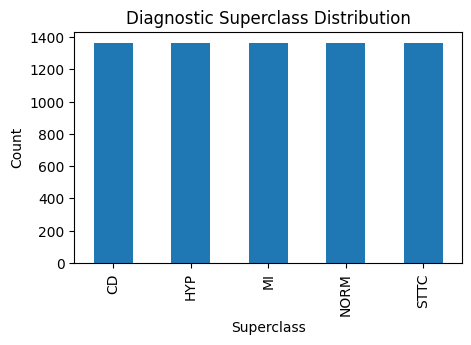

In [16]:
# Plot the newly updated distribution of training examples in each subset (same code as before). 
plt.figure(figsize=(5,3))
pd.Series(y_train).value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

### Split Data

In [17]:
# Split the training data into train (80%) and validation (20%) sets.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42, shuffle=True)

In [18]:
# Print the shapes of the new train and validation sets.
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape, '\n')
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape, '\n')
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (5460, 1000, 12)
Training labels shape: (5460,) 

Validation data shape: (1365, 1000, 12)
Validation labels shape: (1365,) 

Test data shape: (4360, 1000, 12)
Test labels shape: (4360,)


### Normalize Data

In [19]:
# Completely flatten the training data so we can find the min and max values in the training data.
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-16.32 10.547


In [20]:
def normalize(data):
    '''Normalize the data. Logic borrowed from class lab.'''
    data_mean = data.mean()
    data_sd = data.std()
    return (data - data_mean) / data_sd

X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [21]:
# Completely flatten the training data so we can find the min and max values in the training data after normalizing.
X_train_extra_flat = np.array([ekg.flatten() for ekg in X_train]).flatten()
print(min(X_train_extra_flat), max(X_train_extra_flat))

-64.46269961639425 41.664565428623575


### Baseline Models

Training accuracy: 0.1946886446886447
Validation accuracy: 0.20073260073260074
Test accuracy: 0.2036697247706422


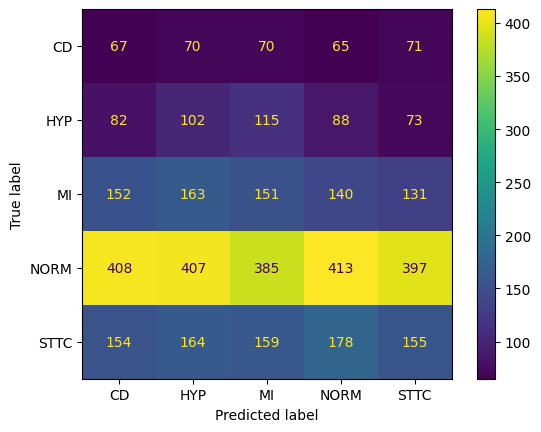

In [22]:
def random_classification(training_data):
    '''For each EKG, predict at random one of the 5 EKG classes.'''
    return [np.random.choice(classes) for _ in training_data]

# Make predictions and evaluate accuracy on the training data.
predictions_train = random_classification(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

# Make predictions and evaluate accuracy on the validation data.
predictions_val = random_classification(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

# Make predictions and evaluate accuracy on the test data.
predictions_test = random_classification(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

# Create a confusion matrix of the predictions on the test data.
random_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=random_cm, display_labels=train_classes).plot();

Training accuracy: 0.20293040293040293
Validation accuracy: 0.18827838827838828
Test accuracy: 0.4610091743119266


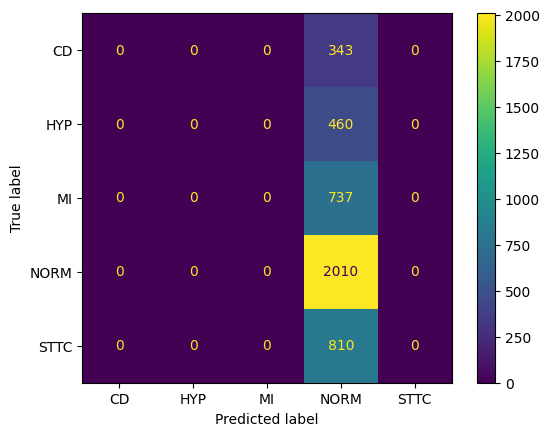

In [23]:
def always_classify_normal(training_data):
    '''For each EKG, predict NORM (the most common EKG class).'''
    return ['NORM'] * len(training_data)

# Make predictions and evaluate accuracy on the training data.
predictions_train = always_classify_normal(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

# Make predictions and evaluate accuracy on the validation data.
predictions_val = always_classify_normal(X_val)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

# Make predictions and evaluate accuracy on the test data.
predictions_test = always_classify_normal(X_test)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

# Create a confusion matrix of the predictions on the test data.
normal_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=normal_cm, display_labels=train_classes).plot();

### Train Models

In [24]:
# Flatten our model inputs so we can run random forest classifier and SVM (comparative models).
X_train_flattened = np.array([ekg.flatten() for ekg in X_train])
print(X_train_flattened.shape)

X_val_flattened = np.array([ekg.flatten() for ekg in X_val])
print(X_val_flattened.shape)

X_test_flattened = np.array([ekg.flatten() for ekg in X_test])
print(X_test_flattened.shape)

(5460, 12000)
(1365, 12000)
(4360, 12000)


**Random Forest Classifier**

Training accuracy: 0.9961538461538462
Validation accuracy: 0.37875457875457874
Test accuracy: 0.46674311926605505


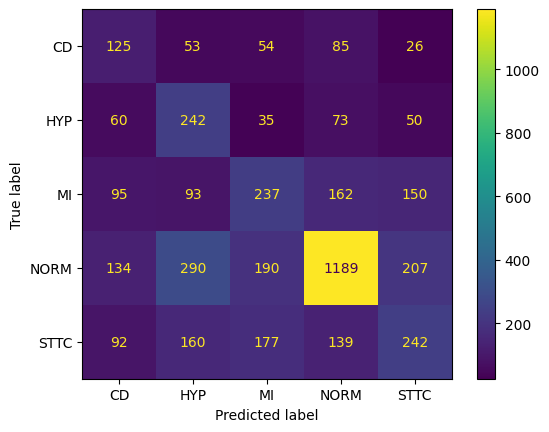

In [25]:
# Fit a random forest classifier to the training data.
rm_model = RandomForestClassifier(n_estimators=100, max_depth = 12).fit(X_train_flattened, y_train) 

# Make predictions and evaluate accuracy on the training data.
predictions_train = rm_model.predict(X_train_flattened)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

# Make predictions and evaluate accuracy on the validation data.
predictions_val = rm_model.predict(X_val_flattened)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

# Make predictions and evaluate accuracy on the test data.
predictions_test = rm_model.predict(X_test_flattened)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

# Create a confusion matrix of the predictions on the test data.
rm_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=rm_cm, display_labels=train_classes).plot();

**Support Vector Machine (SVM)**

Training accuracy: 1.0
Validation accuracy: 0.2153846153846154
Test accuracy: 0.21743119266055047


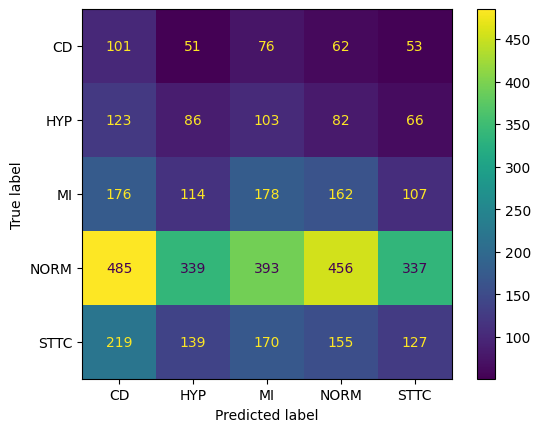

In [26]:
# Fit a SVM classifier to the training data. 
svm_model = SVC(kernel = 'linear', C = 1).fit(X_train_flattened, y_train) 

# Make predictions and evaluate accuracy on the training data.
predictions_train = svm_model.predict(X_train_flattened)
accuracy_train = accuracy_score(y_train, predictions_train)
print('Training accuracy:', accuracy_train)

# Make predictions and evaluate accuracy on the validation data.
predictions_val = svm_model.predict(X_val_flattened)
accuracy_val = accuracy_score(y_val, predictions_val)
print('Validation accuracy:', accuracy_val)

# Make predictions and evaluate accuracy on the test data.
predictions_test = svm_model.predict(X_test_flattened)
accuracy_test = accuracy_score(y_test, predictions_test)
print('Test accuracy:', accuracy_test)

# Create a confusion matrix of the predictions on the test data.
svc_cm = confusion_matrix(y_test, predictions_test, labels=train_classes)
ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=train_classes).plot();

**Neural Network**

In [27]:
# Transform the outputs so we can create a neural network classifier.
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_val = mlb.transform(y_val)
y_test = mlb.transform(y_test)

In [28]:
# Create NN and add various layers.
model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(1000, 12)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))

# Compile the model.
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['categorical_accuracy'])

# Fit the model to the training data and validate with the validation data. 
history = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test data. 
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
test_accuracy

Epoch 1/8
171/171 [==============================] - 6s 35ms/step - loss: 0.6418 - categorical_accuracy: 0.1394 - val_loss: 0.5521 - val_categorical_accuracy: 0.4051
Epoch 2/8
171/171 [==============================] - 6s 33ms/step - loss: 0.5656 - categorical_accuracy: 0.2533 - val_loss: 0.5352 - val_categorical_accuracy: 0.4051
Epoch 3/8
171/171 [==============================] - 6s 32ms/step - loss: 0.5468 - categorical_accuracy: 0.2747 - val_loss: 0.5175 - val_categorical_accuracy: 0.3788
Epoch 4/8
171/171 [==============================] - 6s 33ms/step - loss: 0.5346 - categorical_accuracy: 0.2866 - val_loss: 0.5100 - val_categorical_accuracy: 0.3165
Epoch 5/8
171/171 [==============================] - 6s 33ms/step - loss: 0.5244 - categorical_accuracy: 0.3084 - val_loss: 0.5019 - val_categorical_accuracy: 0.3333
Epoch 6/8
171/171 [==============================] - 6s 33ms/step - loss: 0.5150 - categorical_accuracy: 0.3145 - val_loss: 0.4868 - val_categorical_accuracy: 0.3817
Epoc

0.5587155818939209

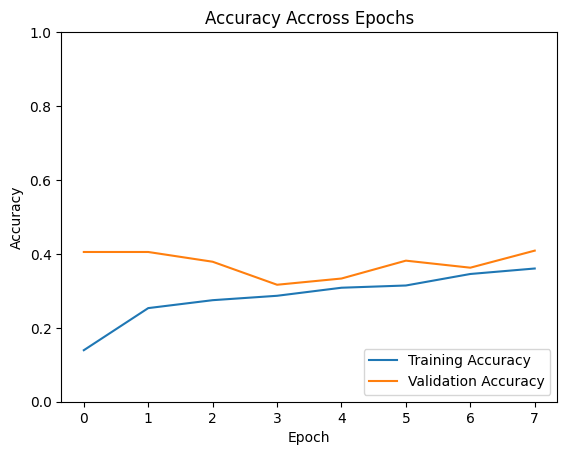

In [31]:
# Plot the training and validation accuracy across epochs of training. 
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy') # Plot the training accuracy.
plt.plot(history.history['val_categorical_accuracy'], label = 'Validation Accuracy') # Plot the validation accuracy. 
plt.xlabel('Epoch') # Set the x label.
plt.ylabel('Accuracy') # Set the y label.
plt.title('Accuracy Accross Epochs') # Set the title.
plt.ylim([0, 1]) # Update the y range. 
plt.legend(loc='lower right') # Add the legend.
plt.show() # Display the plot.